# Explore CaCO3 Coretop Data

This notebook loads and visualizes the CaCO3 coretop data from the CDF file.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Load CaCO3 Coretop Data

In [2]:
# Load CaCO3 coretop data
caco3_ds = xr.open_dataset('datasets/pct_CaCO3.coretop.cdf')
print(caco3_ds)

<xarray.Dataset> Size: 263kB
Dimensions:  (Y: 181, X: 360)
Coordinates:
  * Y        (Y) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * X        (X) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    Pct      (Y, X) float32 261kB ...


In [3]:
# Display data variables and attributes
print("\nData variables:")
for var in caco3_ds.data_vars:
    print(f"  {var}: {caco3_ds[var].shape}")
    print(f"    Attributes: {dict(caco3_ds[var].attrs)}")

print("\nCoordinates:")
for coord in caco3_ds.coords:
    print(f"  {coord}: {caco3_ds[coord].shape}, range: [{float(caco3_ds[coord].min()):.2f}, {float(caco3_ds[coord].max()):.2f}]")

print("\nGlobal attributes:")
for attr in caco3_ds.attrs:
    print(f"  {attr}: {caco3_ds.attrs[attr]}")


Data variables:
  Pct: (181, 360)
    Attributes: {}

Coordinates:
  X: (360,), range: [0.00, 359.00]
  Y: (181,), range: [-90.00, 90.00]

Global attributes:


## Summary Statistics

In [4]:
# Summary statistics for CaCO3 data
print("CaCO3 Data Summary:")
for var in caco3_ds.data_vars:
    print(f"\n{var}:")
    data = caco3_ds[var]
    
    # All data including invalid
    print(f"  Total points: {data.size}")
    
    # Filter valid data (0-100%, finite values)
    valid_data = data.where((data >= 0) & (data <= 100) & np.isfinite(data), drop=True)
    print(f"  Valid points (0-100%): {valid_data.size}")
    print(f"  Invalid points removed: {data.size - valid_data.size}")
    
    if valid_data.size > 0:
        print(f"  Min: {float(valid_data.min()):.2f}%")
        print(f"  Max: {float(valid_data.max()):.2f}%")
        print(f"  Mean: {float(valid_data.mean()):.2f}%")
        print(f"  Median: {float(valid_data.median()):.2f}%")
        print(f"  Std: {float(valid_data.std()):.2f}%")

CaCO3 Data Summary:

Pct:
  Total points: 65160
  Valid points (0-100%): 63000
  Invalid points removed: 2160
  Min: 0.00%
  Max: 98.00%
  Mean: 30.91%
  Median: 22.91%
  Std: 29.59%


## Plot CaCO3 Distribution as Map

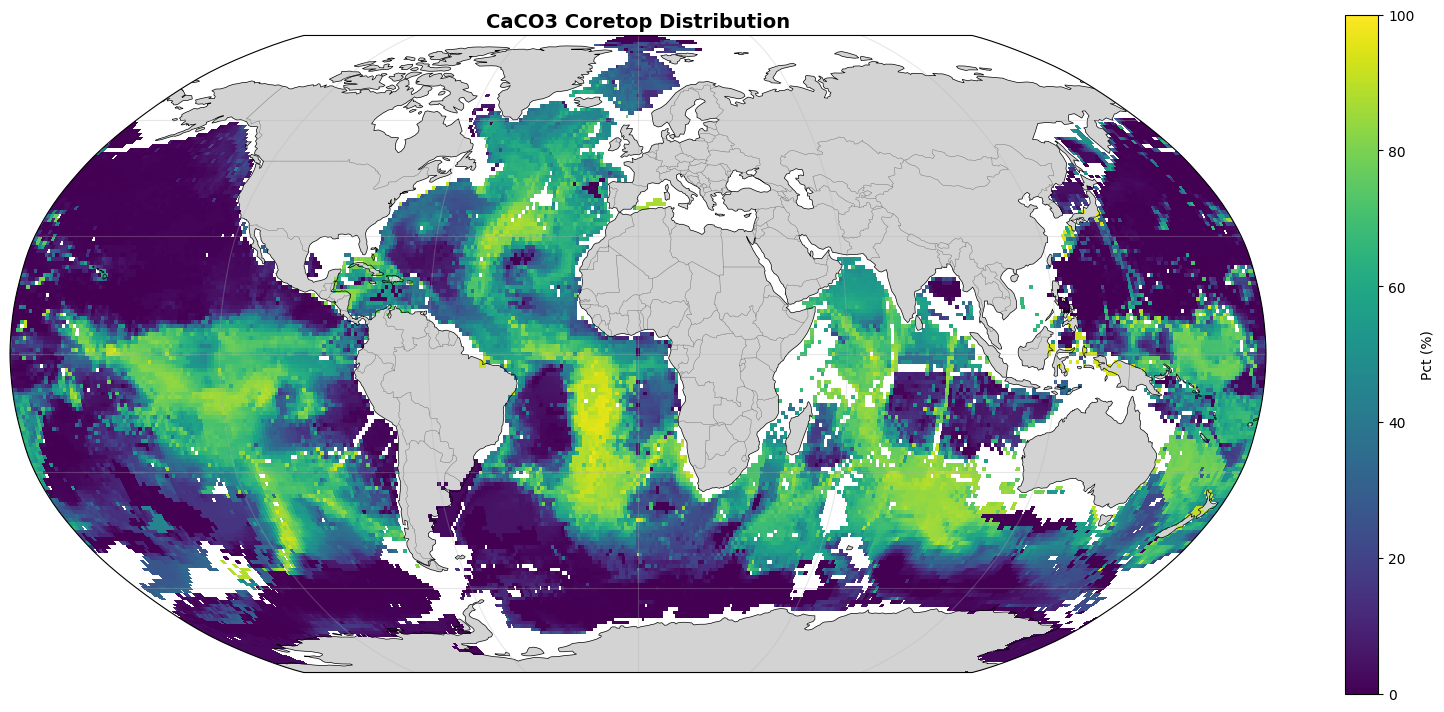

In [5]:
# Get the main variable
var_name = list(caco3_ds.data_vars)[0]
data = caco3_ds[var_name]

# Filter out invalid values (negatives, infinities, and values > 100%)
data_clean = data.where((data >= 0) & (data <= 100) & np.isfinite(data))

# Create map with cartopy
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.Robinson())

# Add features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.5)

# Plot data (X=longitude, Y=latitude)
if 'Y' in data_clean.dims and 'X' in data_clean.dims:
    im = data_clean.plot(ax=ax, transform=ccrs.PlateCarree(),
                    cmap='viridis', vmin=0, vmax=100,
                    cbar_kwargs={'label': f'{var_name} (%)', 'shrink': 0.7})
    ax.set_title(f'CaCO3 Coretop Distribution', fontsize=14, fontweight='bold')
    ax.gridlines(draw_labels=False, alpha=0.3)
else:
    print(f"Data dimensions: {data_clean.dims}")
    print("Cannot create map - no X/Y dimensions found")

plt.tight_layout()
plt.show()

## Plot CaCO3 Histogram

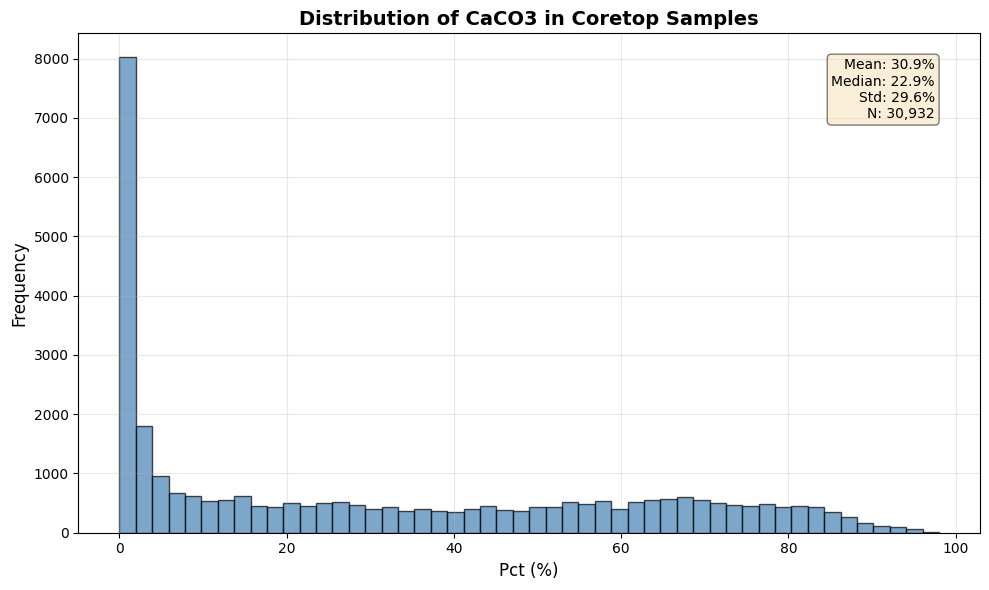

In [6]:
# Histogram of CaCO3 values
fig, ax = plt.subplots(figsize=(10, 6))

var_name = list(caco3_ds.data_vars)[0]
data = caco3_ds[var_name].values.flatten()

# Remove invalid values (NaN, negatives, infinities, values > 100%)
data = data[(~np.isnan(data)) & (data >= 0) & (data <= 100) & np.isfinite(data)]

ax.hist(data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xlabel(f'{var_name} (%)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of CaCO3 in Coretop Samples', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add statistics text
stats_text = f'Mean: {np.mean(data):.1f}%\nMedian: {np.median(data):.1f}%\nStd: {np.std(data):.1f}%\nN: {len(data):,}'
ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, 
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
        fontsize=10)

plt.tight_layout()
plt.show()

## Plot CaCO3 by Ocean Basin

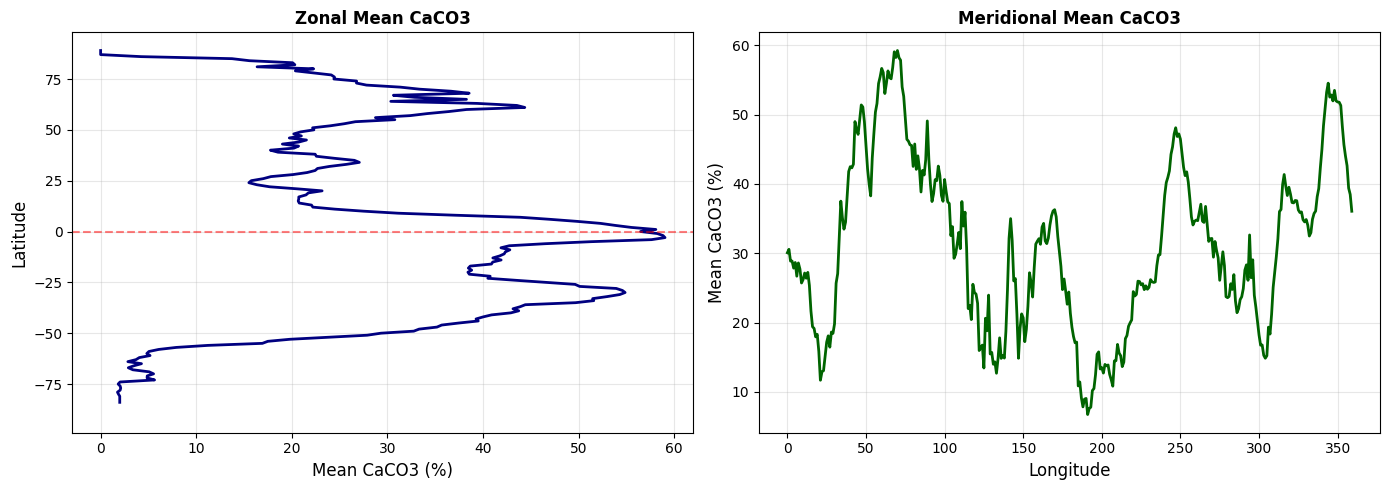

In [7]:
# Create zonal mean plot
var_name = list(caco3_ds.data_vars)[0]
data = caco3_ds[var_name]

# Filter out invalid values (negatives, infinities, and values > 100%)
data_clean = data.where((data >= 0) & (data <= 100) & np.isfinite(data))

if 'Y' in data_clean.dims:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Zonal mean (average across longitudes)
    zonal_mean = data_clean.mean(dim='X', skipna=True)
    ax1.plot(zonal_mean.values, zonal_mean.Y.values, linewidth=2, color='navy')
    ax1.set_xlabel('Mean CaCO3 (%)', fontsize=12)
    ax1.set_ylabel('Latitude', fontsize=12)
    ax1.set_title('Zonal Mean CaCO3', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    # Meridional mean (average across latitudes)
    merid_mean = data_clean.mean(dim='Y', skipna=True)
    ax2.plot(merid_mean.X.values, merid_mean.values, linewidth=2, color='darkgreen')
    ax2.set_xlabel('Longitude', fontsize=12)
    ax2.set_ylabel('Mean CaCO3 (%)', fontsize=12)
    ax2.set_title('Meridional Mean CaCO3', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Cannot create zonal/meridional plots - no Y dimension found")

## Export Data to CSV (Optional)

In [8]:
# Optionally export to CSV for easier analysis
# Uncomment to export
# import pandas as pd
# df = caco3_ds.to_dataframe().reset_index()
# df.to_csv('datasets/CaCO3_coretop_export.csv', index=False)
# print(f"Exported {len(df)} rows to CSV")

In [9]:
# Close dataset
caco3_ds.close()